In [4]:
import torch
from torch.utils.data import DataLoader
import pickle
import os

from utils.config import *
from utils.ortool import *
from utils.Misc import *
#from problems.DVRPSR_Dataset_euclidean import DVRPSR_Dataset_euclidean
from problems import *


## create validation data

args = ParseArguments()
l = 0.0025
batch_size = 10

Lambda = l
dod = 0.1
horizon = 400
vehicle_count = 2

ortool = True

output_dir = "./data/test/{}_{}_{}_{}".format(Lambda, dod, vehicle_count, horizon)

# data_val = DVRPSR_Dataset_euclidean.create_data(batch_size=3, 
#                                                 vehicle_count = 3, 
#                                                 vehicle_speed=1,
#                                                 Lambda=0.2, 
#                                                 dod=0.75, 
#                                                 horizon=600)

data_val = torch.load("./data/validation/{}_{}_{}_{}/val.pth".format(Lambda, dod, vehicle_count, horizon ))

if ortool:
    ortool_routes = ortool_solve(data_val)
data_val.normalize()

env = DVRPSR_Environment(data_val)
if ortool:
    ortool_costs = eval_apriori_routes(env, ortool_routes, rollout_count = 100)
    
torch.save(data_val, os.path.join(output_dir, "val_un.pth"))
if ortool:
    torch.save({'costs':ortool_costs,
               'routes':ortool_routes}, os.path.join(output_dir, "ortool.pth"))

FileNotFoundError: [Errno 2] No such file or directory: './data/validation/0.0025_0.1_2_400/val.pth'

### Plot vehicle routes

In [5]:

def plot_customers(ax, customers, detailed = True):
    r"""
    :param ax:        Axes object to plot to
    :param customers: :math:`L_c \times D_c` tensor containing customers' features
    :param detailed:  Toggle printing features of each customer next to its node
        Default = False
    :type ax:         matplotlib.pyplot.Axes
    :type customers:  torch.Tensor(dtype = torch.float)
    :type detailed:   bool
    """

    ax.axis('equal')
    ax.set_axis_off()
    if detailed:
        ax.set_title("{} customers (Blue:Static, Red:Dynamic)".format(customers.size(0)-1))

    maxdem = customers[1:,3].max().item()
    mindem = customers[1:,3].min().item()
    s = [120+40*(dem-mindem)/(maxdem-mindem+0.2) for dem in customers[1:,3].tolist()]
    cmap = matplotlib.cm.coolwarm

    if customers.size(1) > 3: # Service time
        c = customers[1:,3].tolist()
        cnorm = matplotlib.colors.Normalize(-0.5, 0.5) # service time mean=10, std=2.5 (min)
    else:
        c = [1.0 for _ in customers[1:]]
        cnorm = matplotlib.colors.Normalize(-1, 1)
    
    ax.scatter(*zip(*customers[0:1,:2].tolist()), 200, 'g', 'd')
    ax.scatter(*zip(*customers[1:,:2].tolist()), s, c, 'o', cmap, cnorm)
            
    for j, cust in enumerate( customers.tolist() ):
        ax.text(cust[0],cust[1],str(j), fontsize = 10,
                horizontalalignment = 'center', verticalalignment = 'center')
    return ax


In [6]:
def discrete_cmap(N, base_cmap='ocean'):
    base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [7]:
def plot_vehicle_routes(data_to_plot, routes_without_depot, markersize = 5):

    fig, ax1 = plt.subplots(1, 1, figsize = (10,8))
    
    depot = data_to_plot[0,:2].cpu().numpy()
    locs = data_to_plot[1:,:2].cpu().numpy()

    x_dep, y_dep = depot
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    legend = ax1.legend(loc='upper center')
    cmap = discrete_cmap(len(routes_without_depot) + 2)

    qvs = []
    total_dist = 0

    for veh_number, r in enumerate(routes_without_depot):
        r = np.array(r)
        color = cmap(len(routes_without_depot) - veh_number)
        coords = locs[r-1, :]
        xs, ys = coords.transpose()

        ax1 = plot_customers(ax1, data_to_plot)

        dist = 0
        x_prev, y_prev = x_dep, y_dep

        for (x, y) in coords:
                dist += np.sqrt((x - x_prev) ** 2 + (y - y_prev) ** 2)
                x_prev, y_prev = x, y

        dist += np.sqrt((x_dep - x_prev) ** 2 + (y_dep - y_prev) ** 2)
        total_dist += dist

        xs = np.append(xs,x_dep)
        xs = np.insert(xs,0,x_dep)
        ys = np.append(ys,y_dep)
        ys = np.insert(ys,0,y_dep)


        qv = ax1.quiver(
                        xs[:-1],
                        ys[:-1],
                        xs[1:] - xs[:-1],
                        ys[1:] - ys[:-1],
                        scale_units='xy',
                        angles='xy',
                        scale=1,
                        width = 0.004,
                        color=color,
                        label='Route{}, #Customers {},Distance {:.2f}'.format(
                        veh_number, 
                        len(r), 
                        dist))

        qvs.append(qv)

        ax1.set_title('Blue:Static, Red:Dyanamic,{} routes, total distance {:.2f}'.format(len(routes), total_dist))
        ax1.legend(handles=qvs)


In [8]:
# fig, ax1 = plt.subplots(2, 1, figsize = (16,16))
# plot_customers(ax1[0], data.nodes[1])
# plot_customers(ax1[1], data.nodes[0])

/Users/ajitgupta/anaconda3/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


4.040404040404041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_9974/555589714.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_9974/555589714.py:2: MatplotlibDep

[[4], [5, 7]]
[[9], [7]]
[[10, 4, 3], []]
[[1, 7, 2, 6, 5], [4, 10, 8, 9]]
[[4], []]
[[1, 10, 6, 3, 9, 4], [5, 8, 2, 7]]
[[9, 7], [2]]


/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_9974/555589714.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[2, 5, 10, 6, 9], [4, 8, 7, 1, 3]]


/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_9974/555589714.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_9974/555589714.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap
No artists with labels found to put in legend.  Note that artists whose label start wit

[[6], [3, 2]]
[[4, 5, 2], [9, 6, 3, 10]]
[[6, 9], [4, 2]]
[[8], [6]]
[[9, 1, 10, 8], [4]]
[[10, 1], [4]]
[[5, 9], []]
[[7, 6, 2, 1], []]
[[2, 5], [10, 6, 1, 9]]
[[6], [7]]
[[5, 3, 6, 9, 10], []]
[[5], [6, 2, 3]]


/var/folders/w3/d_8f7c794lx5828018pzxrj40000gn/T/ipykernel_9974/555589714.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap) if isinstance(base_cmap, str) else base_cmap


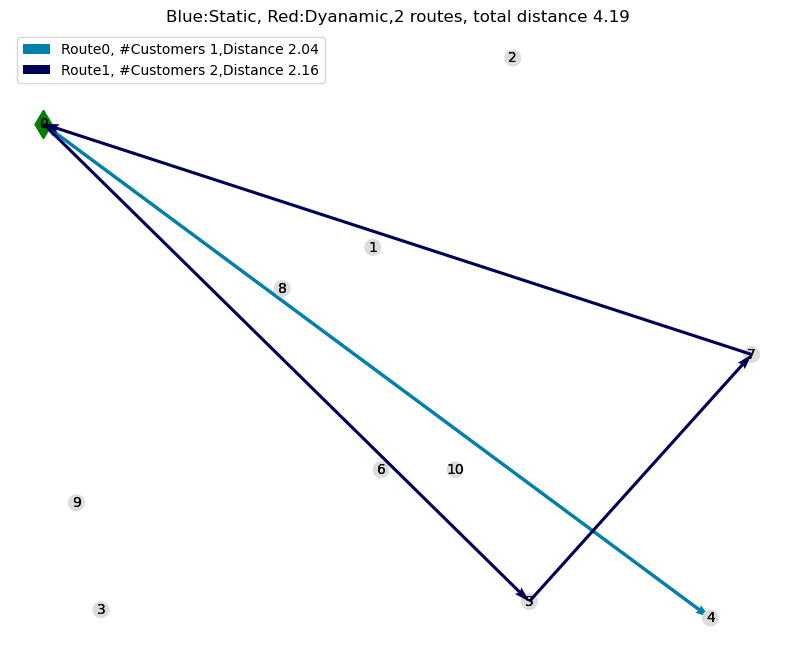

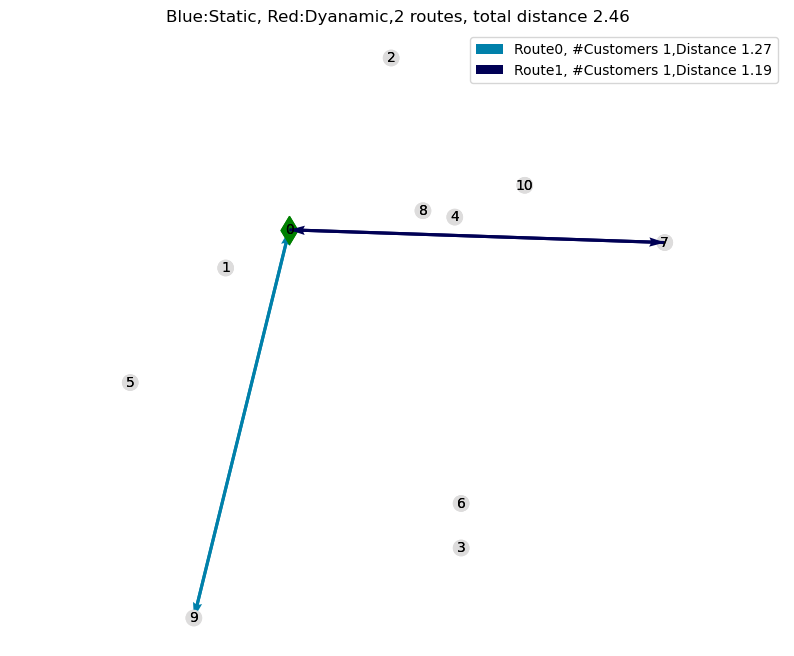

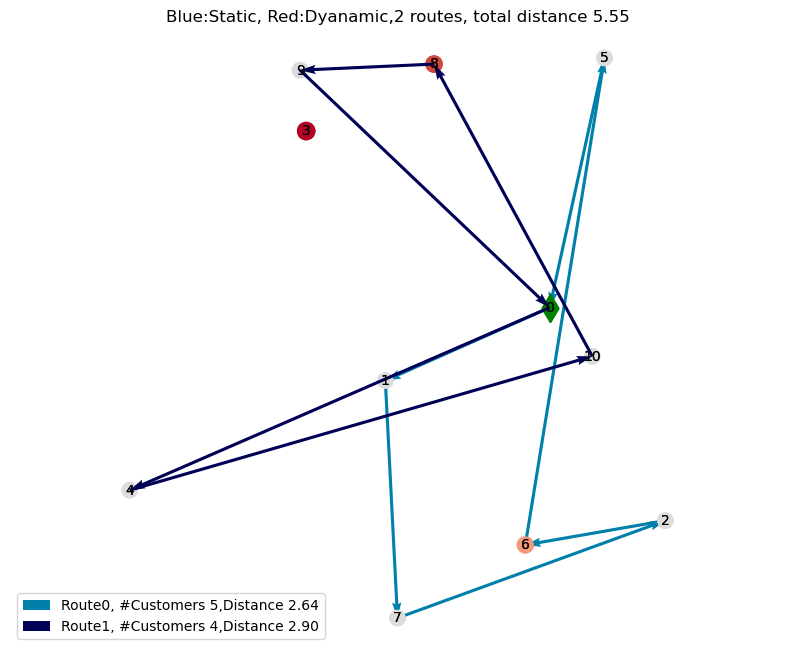

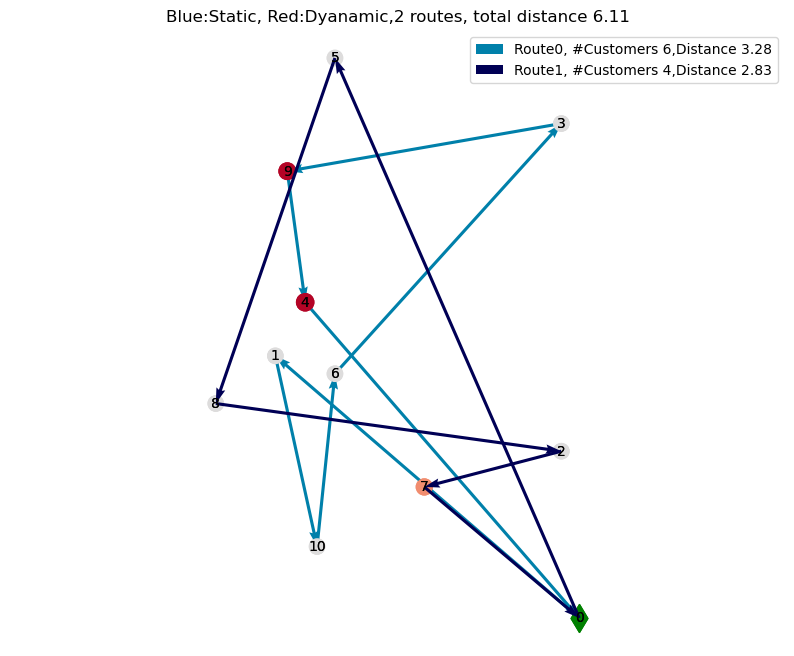

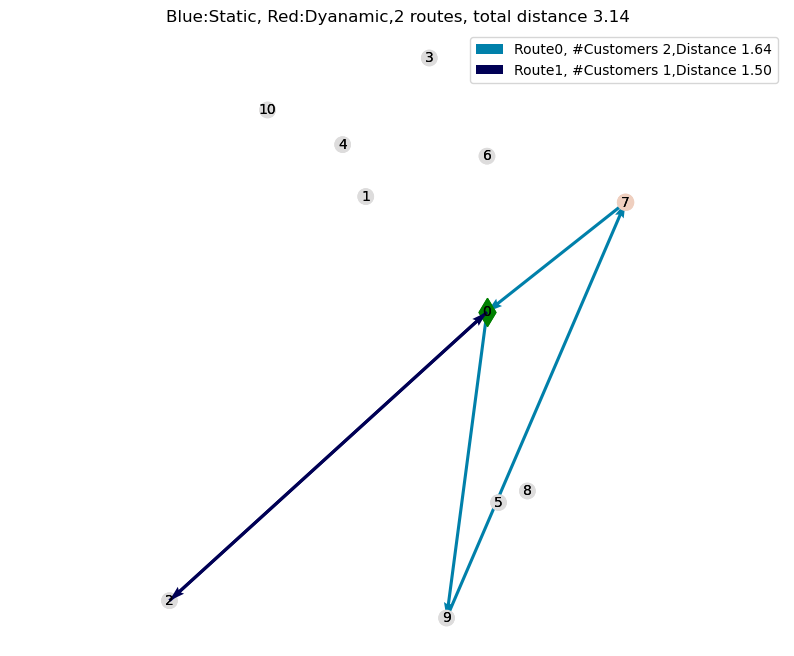

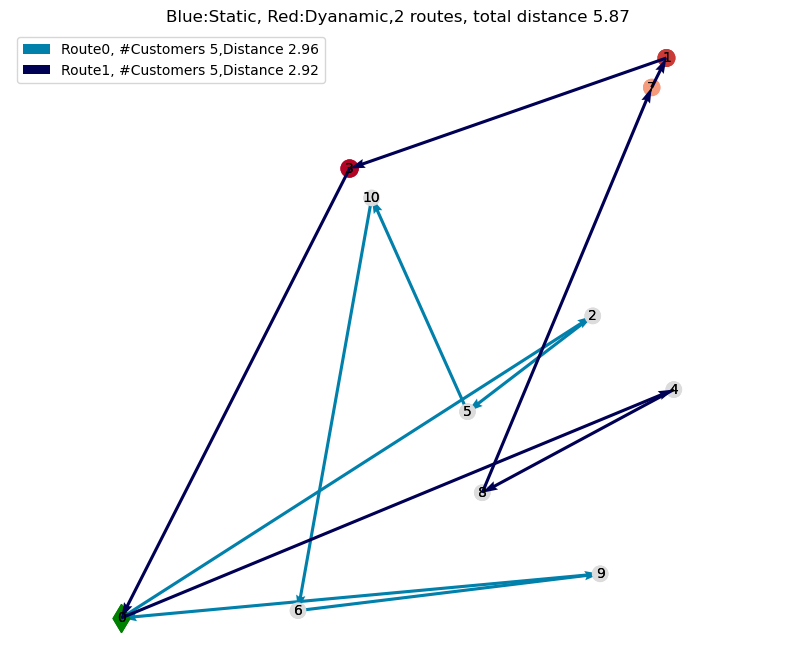

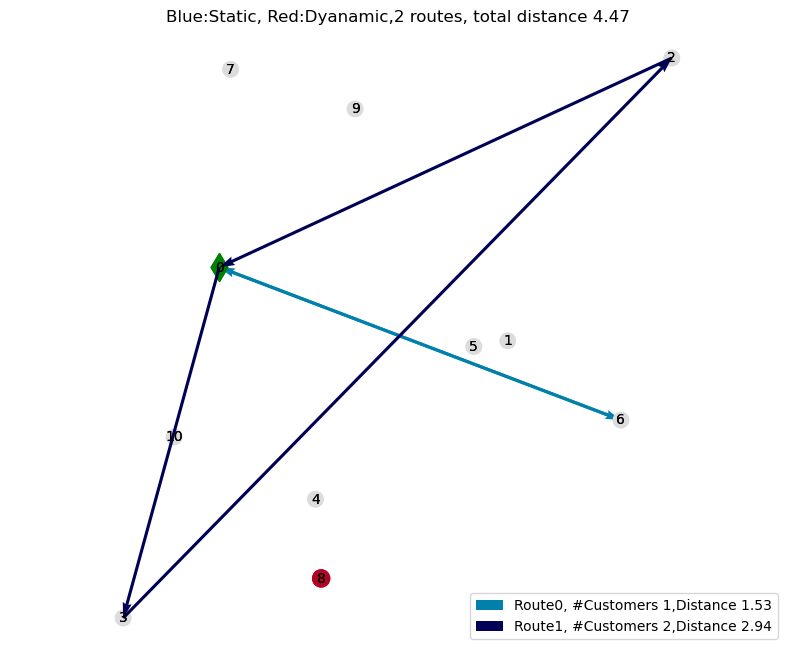

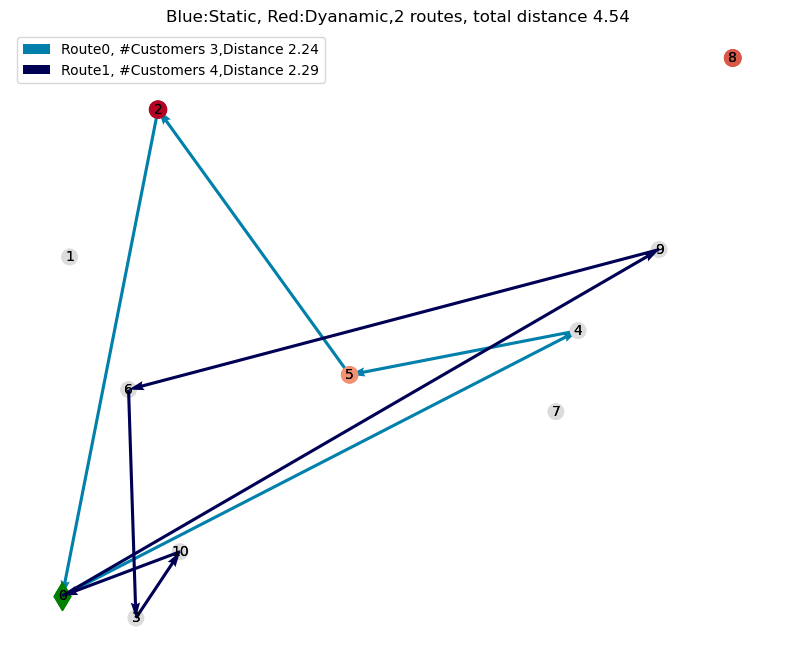

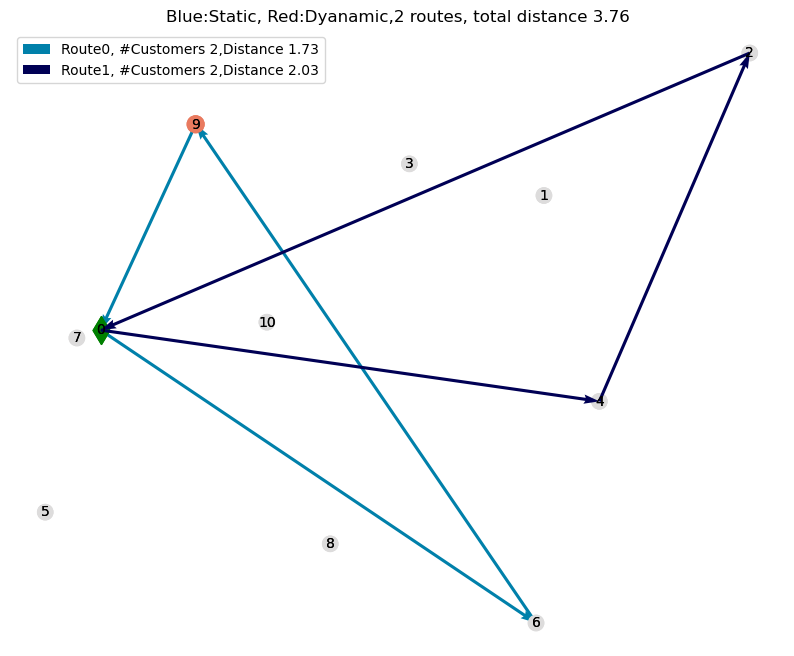

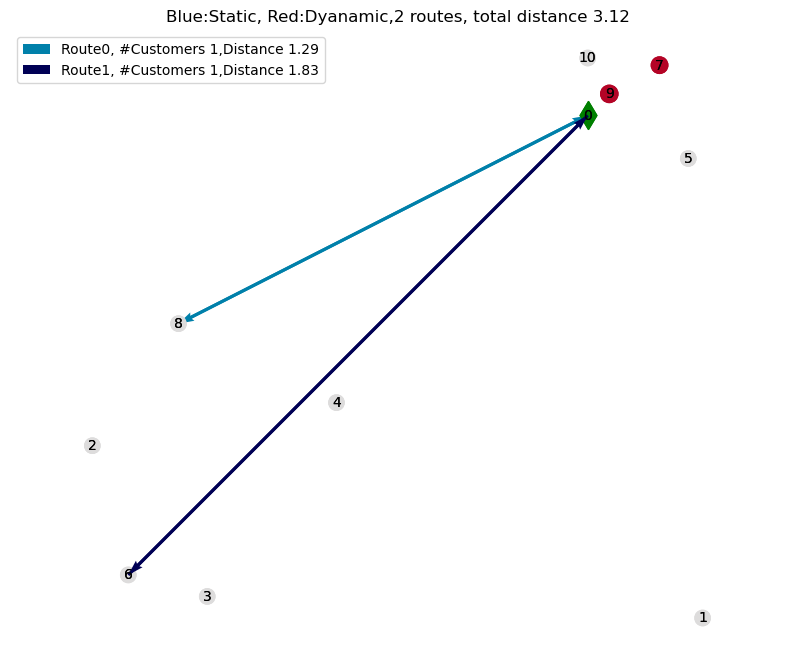

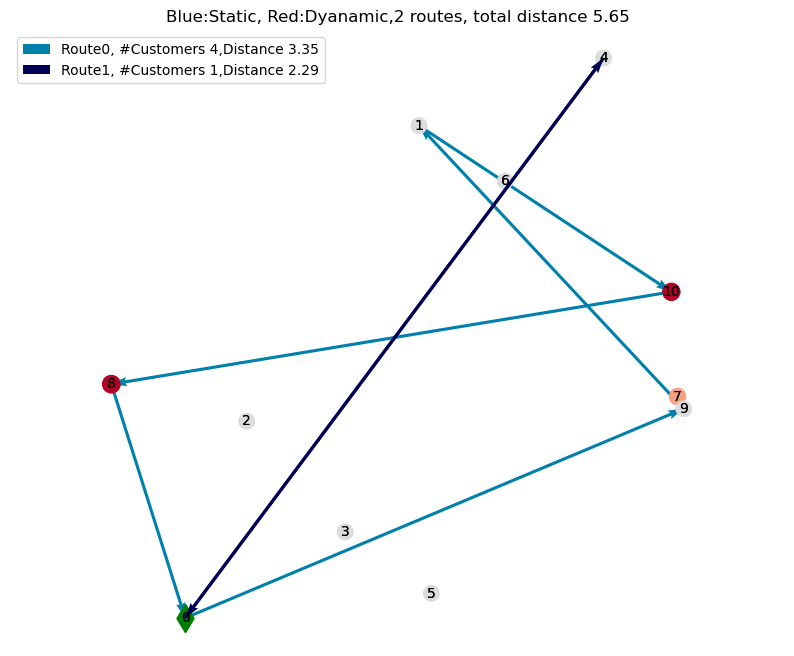

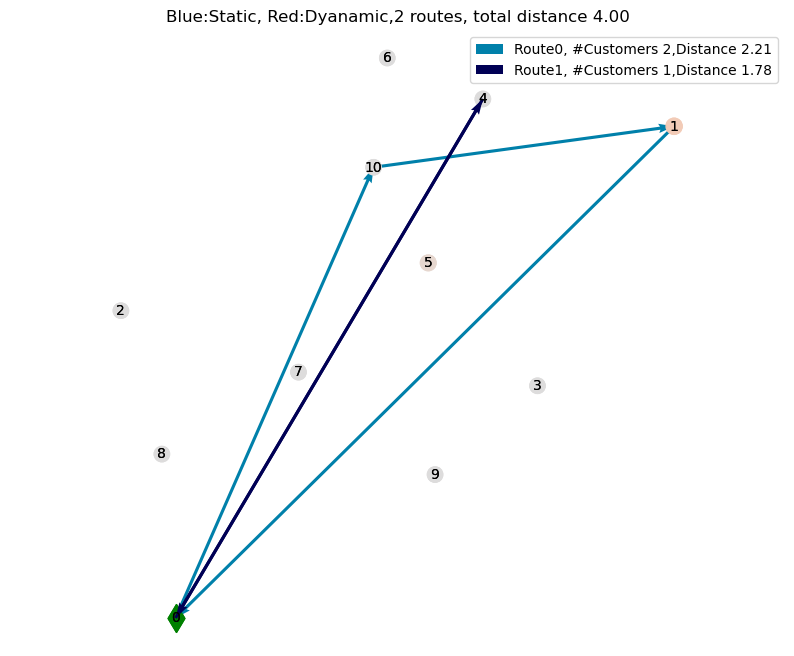

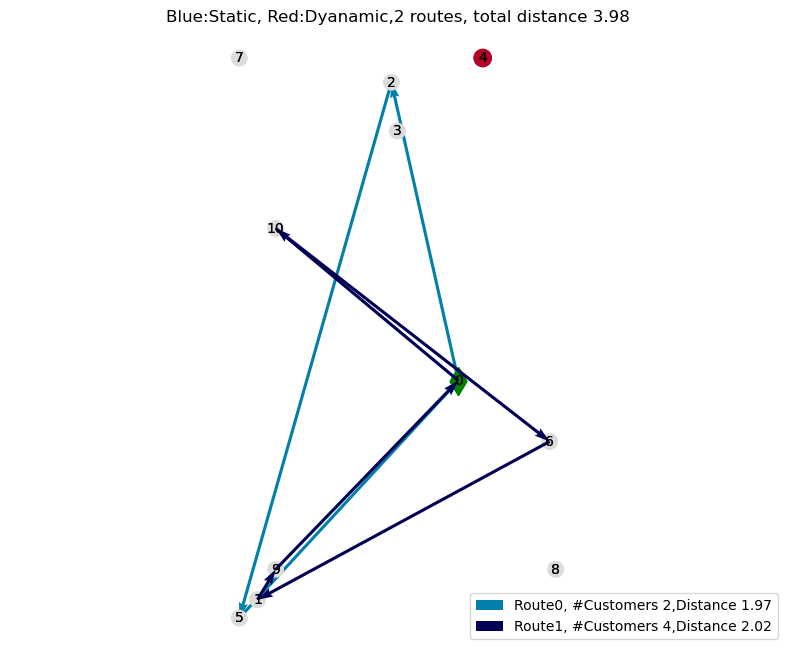

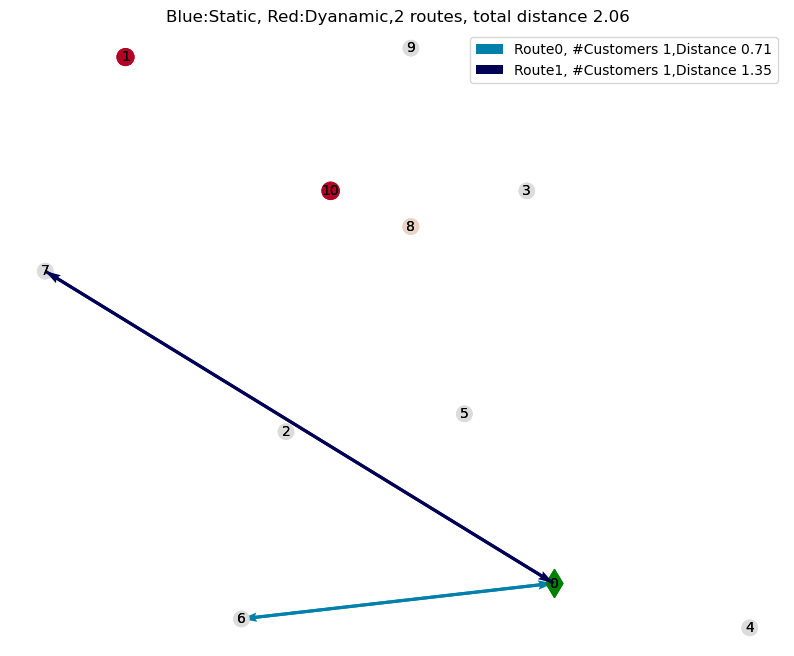

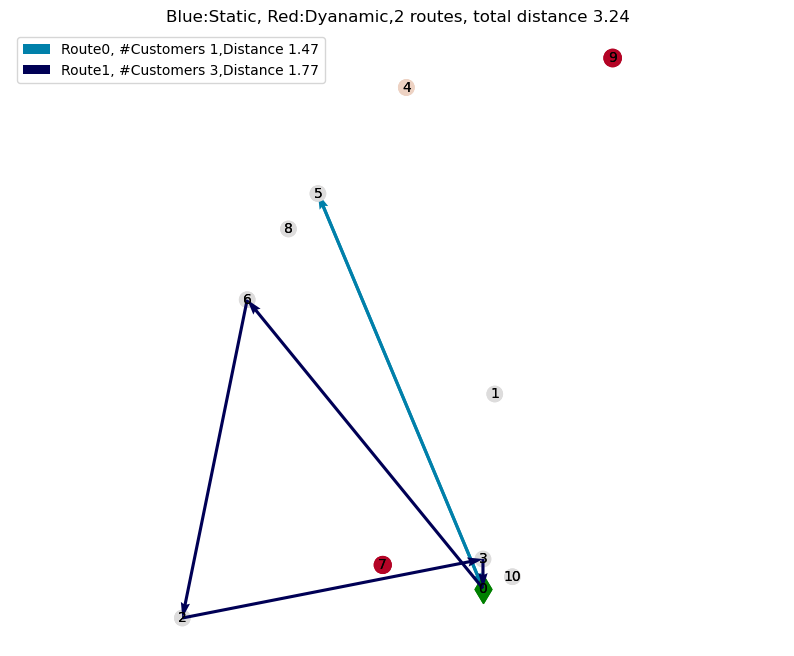

In [10]:
import torch
from torch.utils.data import DataLoader
import itertools

from nets import *
from agents import *
from tqdm import tqdm

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

import torch
import numpy as np

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools
import math
import numpy as np

from nets import *
from tqdm import tqdm
from utils import *
from agents import AgentPPO, Actor_Critic

args = ParseArguments()
Lambda = 0.005
dod = 0.2
horizon = 400
vehicle_count = 2

data = torch.load("./data/validation/{}_{}_{}_{}/val_ung.pth".format(Lambda, dod, vehicle_count, horizon ))

data_t = data
data_t.normalize()
print(data_t.vehicle_speed)
loader = DataLoader(data_t, batch_size=20, shuffle=False)

learner = Actor_Critic(4,6,11, encoder_layer=3, ff_size_critic=128, edge_embedding_dim=64)
checkpoint = torch.load("./output/gtm_debug_{}_{}_{}_230724/epoch2.pth".format(Lambda, dod, vehicle_count), 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True


agent_actions = []
with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DVRPSR_Environment(data = data_t, pending_cost=0, dynamic_reward=0)
        actions,logps, rewards = learner.act(env)
        #print(minibatch[0])
        #print(env.vehicles)
        #print(env.nodes)
        
        agent_actions.append(actions)
        
# Convert tensor to array
agent_actions_to_array = np.array([[[t[0][i].item(), t[1][i].item()] 
                                    for i in range(len(t[0]))] 
                                    for t in agent_actions[0]])
tours = []

for i in range(len(agent_actions_to_array[0])):
    temp = []
    for j in range(len(agent_actions_to_array)):
        temp.append(agent_actions_to_array[j][i])
    tours.append(temp)


for i, (data, tour) in enumerate(zip(env.nodes, tours)):
    
    tour = pd.DataFrame(tour)
    tour.columns = ['vehicles','customers']  
    
    # Create a grouping column
    tour['group'] = tour.groupby('vehicles').cumcount()

    # Reshape the DataFrame
    tour = tour.pivot(index='group', columns='vehicles', values='customers')

    # Rename the columns
    column_names = [f'vehicles_{val}' for val in tour.columns]
    tour.columns = column_names
    tour = tour.fillna(0).astype(int)

    routes = []
    for vehicle_name in list(tour.columns):
        routes.append(list(tour[vehicle_name]))

    routes_without_depot = []
    for route in routes:
        r = [cust for cust in route if cust!=0]
        routes_without_depot.append(r)
        
    print(routes_without_depot)
    if ((len(routes_without_depot[1]) > 0 ) and (len(routes_without_depot[0]) > 0)):
        plot_vehicle_routes(data, routes_without_depot)
    

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools
import math
import numpy as np

from nets import *
from tqdm import tqdm
from utils import *
from agents import AgentPPO, Actor_Critic

args = ParseArguments()
Lambda = 0.025
dod = 0.5
horizon = 400
vehicle_count = 2

data = torch.load("./data/validation/{}_{}_{}_{}/val_ar.pth".format(Lambda, dod, vehicle_count, horizon ))
data.normalize()
loader = DataLoader(data, batch_size=512)

learner = Actor_Critic(4,6,21, ff_size_critic=128, encoder_layer=3, edge_embedding_dim=64)
checkpoint = torch.load("./pretrained/{}_{}_{}_{}/epoch8.pth".format(Lambda, dod, vehicle_count, horizon ), 
                        map_location = 'cpu')

learner.load_state_dict(checkpoint['model'])
learner.eval()
learner.greedy  = True

costs = []
acceptance_rate = []


with torch.no_grad():
    for _, minibatch in enumerate(tqdm(loader)):
        env = DVRPSR_Environment(None, minibatch[0],minibatch[1], pending_cost=0, dynamic_reward=0)
        actions,_, rewards = learner.act(env)
        #print(actions)
        #print(env.vehicles)
        costs.append(torch.stack([rewards]).sum(dim=0).squeeze(-1))
        
        total_dynamic_requests = (env.nodes[:,:,3]>0).sum(1).float()
        total_dynamic_requests_pending = (torch.logical_and(env.served^True, (env.nodes[:,:,3]>0))).sum(1).float()
        acceptance_rate.append(1 - total_dynamic_requests_pending/total_dynamic_requests)
        
    costs = torch.cat(costs, 0)
    acceptance_rate = torch.cat(acceptance_rate, 0)
    #print(acceptance_rate)
    
acceptance_rate = [0 if math.isnan(x) else x for x in acceptance_rate]
    

print("Costs mean:{:.2f} +- std:{:.2f} and Acceptance rate {:.2f}".format(costs.mean(), 
                                                                          costs.std(),
                                                                          np.mean(acceptance_rate)))     
        
# torch.save({"costs":costs,
#             "acceptance_rate":acceptance_rate},
#             "./results/DVRPSR_{}_{}_{}_{}/MAAM.pth".format(Lambda, dod, vehicle_count, horizon ))  



NameError: name 'ParseArguments' is not defined